In [1]:
# Add local scripts to module search path
import sys
import os
sys.path.append(os.path.realpath('../toliman-proper'))

In [2]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
def wrapcb(im):
    ax = plt.gca()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)

Ensure that the spiral pupil function gives the expected Fourier transform.

## Pupil OPD map

Phase pupil uses a function to define the optical path difference introduced at each position on a grid, which induces a phase shift (proportional to the wavelength).

In [3]:
#from gen_opdmap import gen_opdmap
from gen_opdmap import gen_opdmap
from spirals import binarized_ringed_flipped

# This is the pupil function
def binarized_ringed_650(r, phi):
    opd = 650.*1e-9*0.5
    return binarized_ringed_flipped(r, phi, opd)

# Values pulled from a recent run of proper for the toliman config 
gridsize = 2048
sampling = 0.00036621093749999995 # m/sample
opdmap = gen_opdmap(binarized_ringed_650, gridsize, 0.00036621093749999995, use_cached=False, save_cached=False)

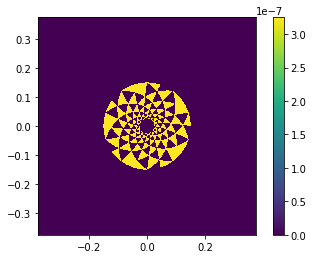

In [4]:
import matplotlib.pyplot as plt
plt.imshow(opdmap,cmap='viridis',extent=[x*sampling for x in [-gridsize/2,gridsize/2,-gridsize/2,gridsize/2]])
plt.colorbar()
plt.show()

## Pupil plane wavefront

Treat the wavefront as a uniform plane, confined to an annulus bounded by the extent of the primary and obscured in the centre by the secondary mirror.

In [5]:
import numpy as np
import math
aperture = np.ones((gridsize,gridsize), dtype=complex)
# Exclude inner and outer regions corresponding to those defined in Keiran's original code
c = gridsize/2.
scale = 0.15/300.
for i in range(gridsize):
    for j in range(gridsize):
        x = i - c
        y = j - c
        r = sampling*math.hypot(x,y)/scale
        if(r>300 or r<50):
            aperture[i][j] *= 0

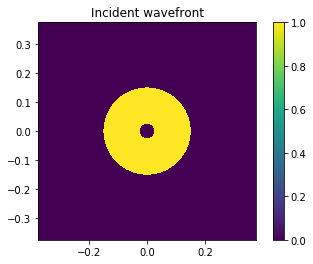

In [6]:
# Visualise the incident wavefront
plt.imshow(np.abs(aperture),cmap='viridis',extent=[x*sampling for x in [-gridsize/2,gridsize/2,-gridsize/2,gridsize/2]])
plt.colorbar()
plt.title('Incident wavefront')
plt.show()

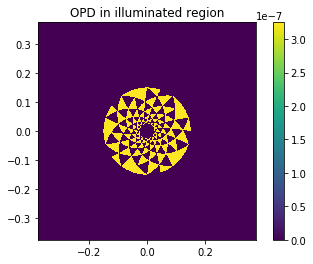

In [7]:
# Visualise the OPD introduced by the phase pupil
# (Check pupil features are retained within this region)
plt.imshow(np.abs(np.multiply(aperture,opdmap)),cmap='viridis',extent=[x*sampling for x in [-gridsize/2,gridsize/2,-gridsize/2,gridsize/2]])
plt.colorbar()
plt.title('OPD in illuminated region')
plt.show()

## Image plane PSF

Vary the incident wavelength and calculate the phase introduced at the pupil, and the associated Fourier Transform, equivalent to the image plane PSF.

The phase is calculated for each grid element of the OPD map as
$$
\phi_{x,y} = \frac{2\pi d_{x,y}}{\lambda}
$$
such that the complex wavefront becomes
$$
\mathrm{wf}_{x,y} = A_{x,y} \exp(i\phi_{x,y})
$$
where $d_{x,y}$ is the OPD at location ($x$,$y$) and $A_{x,y}$ is the incident wavefront amplitude.

600.0


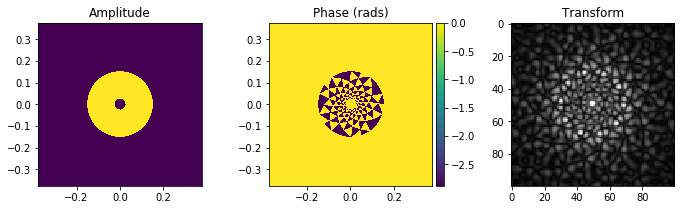

625.0


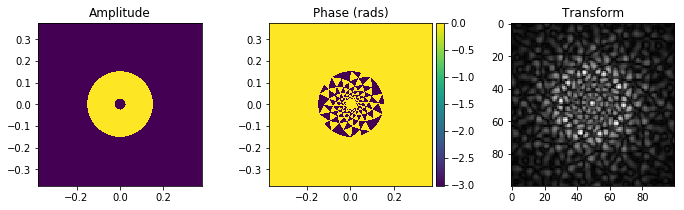

650.0


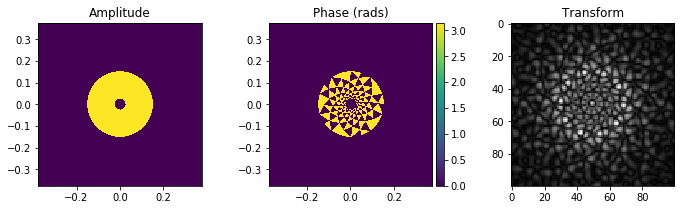

In [8]:
import numpy as np
import math
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable


for wl in 600., 625.,650.:
    print(wl)
    fig, axes = plt.subplots(1, 3, figsize=(12,3))

    wf = np.exp((2*np.pi*complex(0., 1.)*opdmap/(wl*1e-9)))
    # Retain only illuminated region
    wf = np.multiply(wf, aperture)
    plt.axes(axes[0])
    plt.imshow(np.abs(wf),cmap='viridis',extent=[x*sampling for x in [-gridsize/2,gridsize/2,-gridsize/2,gridsize/2]])
    plt.title('Amplitude')

    plt.axes(axes[1])
    im = plt.imshow(np.angle(wf),cmap='viridis',extent=[x*sampling for x in [-gridsize/2,gridsize/2,-gridsize/2,gridsize/2]])
    plt.title('Phase (rads)')
    divider = make_axes_locatable(axes[1])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)

    # Calculate Fourier transform
    ft = np.fft.fftshift(np.fft.fft2(wf))

    plt.axes(axes[2])
    # Peak value is around 500000, but clip at lower value to emphasise rest of image
    im = plt.imshow(np.abs(ft[975:1075,975:1075]),vmax=60000, cmap=plt.get_cmap('gray'))
    plt.title('Transform')

    plt.show()

In [9]:
# Export FITS file
import pyfits
if False:
    wf = np.multiply(np.exp((2*np.pi*complex(0., 1.)*phasemap*a/(wl*1e-9))), aperture)
    hdu = pyfits.PrimaryHDU(phasemap)
    hdu.writeto('pupil_spiral-650nm_opd.fits')
    hdu = pyfits.PrimaryHDU(np.abs(wf))
    hdu.writeto('pupil_spiral-650nm_wavefront_amp.fits')
    hdu = pyfits.PrimaryHDU(np.angle(ft))
    hdu.writeto('pupil_spiral-650nm_wavefront_phase.fits')

/home/ubuntu/miniconda/envs/astroconda/lib/python3.5/site-packages/pyfits/__init__.py:22: PyFITSDeprecationWarning: PyFITS is deprecated, please use astropy.io.fits
  PyFITSDeprecationWarning)  # noqa


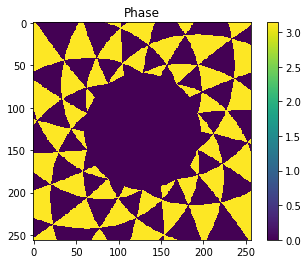

In [10]:
# Close-up of the phase in the centre
wl = 650.
wf = np.multiply(np.exp((2*np.pi*complex(0., 1.)*opdmap/(wl*1e-9))), aperture)
im = plt.imshow(np.angle(wf)[1024-128:1024+128,1024-128:1024+128],cmap='viridis')#,extent=[x*sampling for x in [0,gridsize,0,gridsize]])
plt.title('Phase')
plt.colorbar()
plt.show()

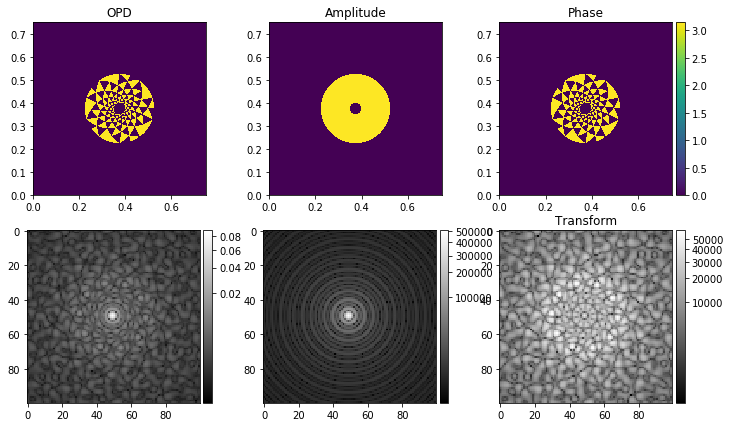

In [11]:
# Compare FTs of each step
import numpy as np
import math
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable

wl=650.
fig, axes = plt.subplots(2, 3, figsize=(12,7))

plt.axes(axes[0][0])
plt.imshow(opdmap,cmap='viridis',extent=[x*sampling for x in [0,gridsize,0,gridsize]])
plt.title('OPD')

plt.axes(axes[1][0])
im = plt.imshow(np.abs(np.fft.fftshift(np.fft.fft2(opdmap))[975:1075,975:1075]), cmap=plt.get_cmap('gray'),norm=mcolors.PowerNorm(gamma=0.3))
divider = make_axes_locatable(axes[1][0])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)

wf = np.exp((2*np.pi*complex(0., 1.)/(wl*1e-9))*opdmap)
# Retain only illuminated region
wf = np.multiply(wf, aperture)

plt.axes(axes[0][1])
plt.imshow(np.abs(wf),cmap='viridis',extent=[x*sampling for x in [0,gridsize,0,gridsize]])
plt.title('Amplitude')

plt.axes(axes[1][1])
im = plt.imshow(np.abs(np.fft.fftshift(np.fft.fft2(aperture))[975:1075,975:1075]), cmap=plt.get_cmap('gray'),norm=mcolors.PowerNorm(gamma=0.3))
divider = make_axes_locatable(axes[1][1])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)

plt.axes(axes[0][2])
im = plt.imshow(np.angle(wf),cmap='viridis',extent=[x*sampling for x in [0,gridsize,0,gridsize]])
plt.title('Phase')
divider = make_axes_locatable(axes[0][2])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)

# Calculate Fourier transform
ft = np.fft.fftshift(np.fft.fft2(wf))

plt.axes(axes[1][2])
# Peak value is around 500000, but clip at lower value to emphasise rest of image
im = plt.imshow(np.abs(ft[975:1075,975:1075]), cmap=plt.get_cmap('gray'),norm=mcolors.PowerNorm(gamma=0.3))
plt.title('Transform')
divider = make_axes_locatable(axes[1][2])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)

plt.show()

## Deconstruct wavefront

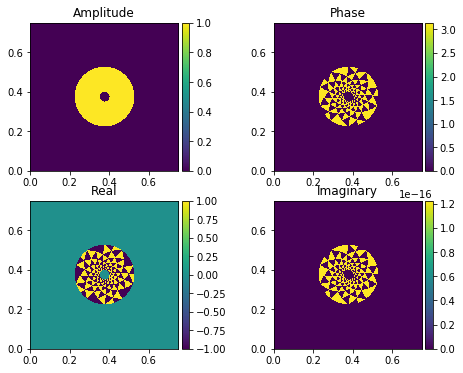

In [12]:
wl=650.

wf = np.multiply(np.exp((2*np.pi*complex(0., 1.)/(wl*1e-9))*opdmap), aperture)

fig, axes = plt.subplots(2, 2, figsize=(8,6))

plt.axes(axes[0][0])
plt.title('Amplitude')
wrapcb(plt.imshow(np.abs(wf),cmap='viridis',extent=[x*sampling for x in [0,gridsize,0,gridsize]]))

plt.axes(axes[0][1])
plt.title('Phase')
wrapcb(plt.imshow(np.angle(wf),cmap='viridis',extent=[x*sampling for x in [0,gridsize,0,gridsize]]))

plt.axes(axes[1][0])
plt.title('Real')
wrapcb(plt.imshow(np.real(wf),cmap='viridis',extent=[x*sampling for x in [0,gridsize,0,gridsize]]))

plt.axes(axes[1][1])
plt.title('Imaginary')
wrapcb(plt.imshow(np.imag(wf),cmap='viridis',extent=[x*sampling for x in [0,gridsize,0,gridsize]]))


plt.show()

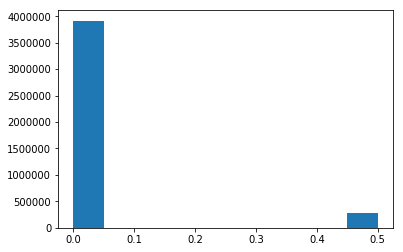

OPD values from 0.0 to 0.5 lambda


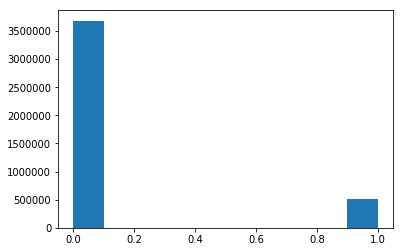

Wavefront magnitude values from 0.0 to 1.0


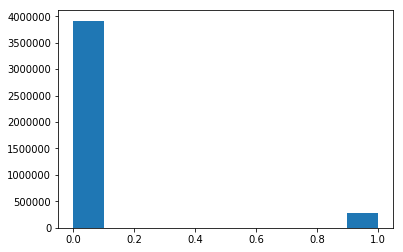

Wavefront angles values from 0.0 to 1.0 pi


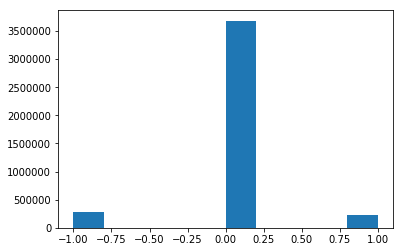

Wavefront real values from -1.0 to 1.0


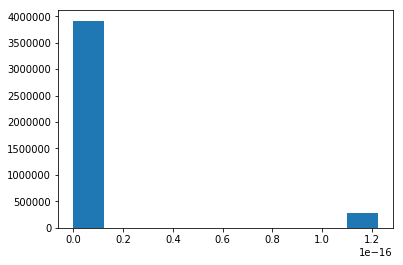

Wavefront imaginary values from 0.0 to 1.2246467991473532e-16


In [13]:
opd_values = (opdmap/(wl*1e-9)).flatten()
plt.hist(opd_values)
plt.show()
print('OPD values from {} to {} lambda'.format(np.min(opd_values),np.max(opd_values)))
amp_values = np.abs(wf).flatten()
plt.hist(amp_values)
plt.show()
print('Wavefront magnitude values from {} to {}'.format(np.min(amp_values),np.max(amp_values)))
phase_values = np.angle(wf).flatten()/np.pi
plt.hist(phase_values)
plt.show()
print('Wavefront angles values from {} to {} pi'.format(np.min(phase_values),np.max(phase_values)))
real_values = np.real(wf).flatten()
plt.hist(real_values)
plt.show()
print('Wavefront real values from {} to {}'.format(np.min(real_values),np.max(real_values)))
im_values = np.imag(wf).flatten()
plt.hist(im_values)
plt.show()
print('Wavefront imaginary values from {} to {}'.format(np.min(im_values),np.max(im_values)))

The imaginary component looks very small. De Moivre form $\exp(i\theta)=\cos(\theta) + i\sin(\theta)$ so if we have phase shifts of $\{0,\pi\}$ we should have real components of $\{1,-1\}$ and imaginary components of $\{0,0\}$. So values appear reasonable.

## Round-trip test Wavefront-PSF-Wavefront

From Kieran: "FFT is wrong.  When I inverse FFT this the pupil I get is wrong.  It is real and positive when it should be real and +/-.  So why is the  pupil real and positive?"

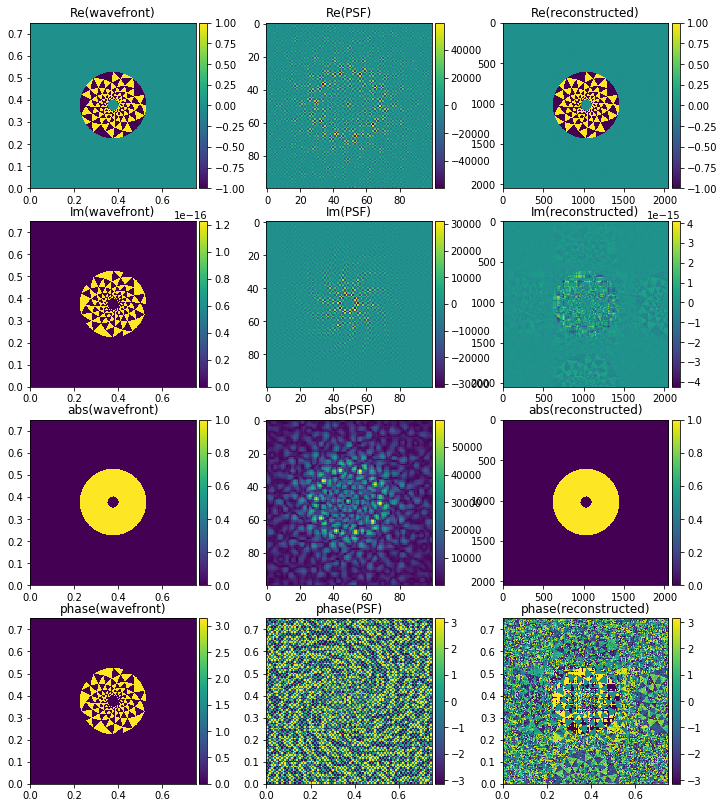

In [14]:
wl = 650.

fig, axes = plt.subplots(4, 3, figsize=(12,14))

wf = np.multiply(np.exp((2*np.pi*complex(0., 1.)/(wl*1e-9))*opdmap), aperture)
plt.axes(axes[0][0])
plt.title('Re(wavefront)')
wrapcb(plt.imshow(np.real(wf),cmap='viridis',extent=[x*sampling for x in [0,gridsize,0,gridsize]]))
plt.axes(axes[1][0])
plt.title('Im(wavefront)')
wrapcb(plt.imshow(np.imag(wf),cmap='viridis',extent=[x*sampling for x in [0,gridsize,0,gridsize]]))
plt.axes(axes[2][0])
plt.title('abs(wavefront)')
wrapcb(plt.imshow(np.abs(wf),cmap='viridis',extent=[x*sampling for x in [0,gridsize,0,gridsize]]))
plt.axes(axes[3][0])
plt.title('phase(wavefront)')
wrapcb(plt.imshow(np.angle(wf),cmap='viridis',extent=[x*sampling for x in [0,gridsize,0,gridsize]]))

ft = np.fft.fft2(wf)
ft_shifted = np.fft.fftshift(ft)
plt.axes(axes[0][1])
plt.title('Re(PSF)')
wrapcb(plt.imshow(np.real(ft_shifted[975:1075,975:1075]),cmap='viridis'))
plt.axes(axes[1][1])
plt.title('Im(PSF)')
wrapcb(plt.imshow(np.imag(ft_shifted[975:1075,975:1075]),cmap='viridis'))
plt.axes(axes[2][1])
plt.title('abs(PSF)')
wrapcb(plt.imshow(np.abs(ft_shifted[975:1075,975:1075]),cmap='viridis'))
plt.axes(axes[3][1])
plt.title('phase(PSF)')
wrapcb(plt.imshow(np.angle(ft_shifted[975:1075,975:1075]),cmap='viridis',extent=[x*sampling for x in [0,gridsize,0,gridsize]]))

ift = np.fft.ifft2(ft)
plt.axes(axes[0][2])
plt.title('Re(reconstructed)')
wrapcb(plt.imshow(np.real(ift),cmap='viridis'))
plt.axes(axes[1][2])
plt.title('Im(reconstructed)')
wrapcb(plt.imshow(np.imag(ift),cmap='viridis'))
plt.axes(axes[2][2])
plt.title('abs(reconstructed)')
wrapcb(plt.imshow(np.abs(ift),cmap='viridis'))
plt.axes(axes[3][2])
plt.title('phase(reconstructed)')
wrapcb(plt.imshow(np.angle(ift),cmap='viridis',extent=[x*sampling for x in [0,gridsize,0,gridsize]]))

plt.show()

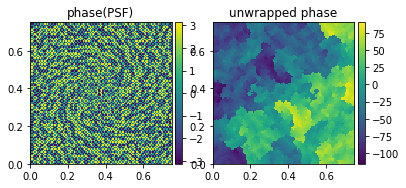

In [15]:
from skimage.restoration import unwrap_phase

fig, axes = plt.subplots(1, 2, figsize=(6,16))
plt.axes(axes[0])
plt.title('phase(PSF)')
wrapcb(plt.imshow(np.angle(ft_shifted[975:1075,975:1075]),cmap='viridis',extent=[x*sampling for x in [0,gridsize,0,gridsize]]))
plt.axes(axes[1])
plt.title('unwrapped phase')
wrapcb(plt.imshow(unwrap_phase(np.angle(ft_shifted[975:1075,975:1075])),cmap='viridis',extent=[x*sampling for x in [0,gridsize,0,gridsize]]))
plt.show()

# Step through wavelengths

Match Kieran's 11 wavelengths spanning 600 to 650nm inclusive

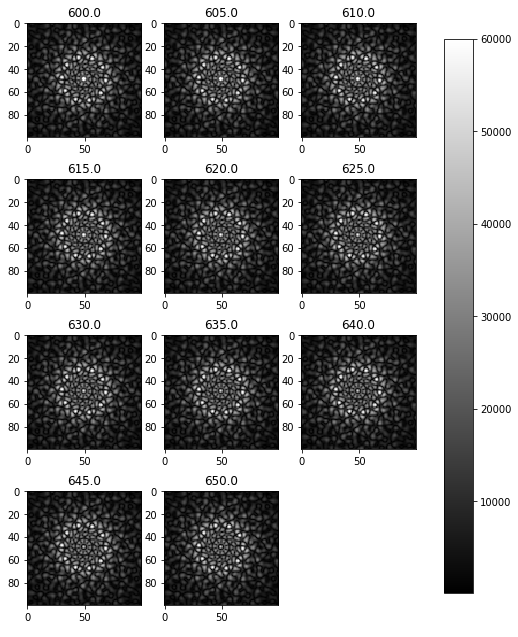

In [16]:
import numpy as np
import math
import matplotlib.colors as mcolors

delta = 5. #nm
n_wl = 11
fig, axes = plt.subplots(4, 3, figsize=(8,11))
for wl,ax in zip([600.+delta*d for d in range(n_wl)], axes.reshape(-1)):
    # Convert OPDS in opdmap to wavelength-specific complex phase 
    wf = np.exp((2*np.pi*complex(0., 1.)/(wl*1e-9))*opdmap)
    
    # Retain only illuminated region
    wf = np.multiply(wf, aperture)
    
    # Calculate Fourier transform
    ft = np.fft.fftshift(np.fft.fft2(wf))
    plt.axes(ax)
    # Peak value is around 500000, but clip at lower value to emphasise rest of image
    im = plt.imshow(np.abs(ft[975:1075,975:1075]),vmax=60000, cmap=plt.get_cmap('gray'))
    plt.title(wl)
axes[-1,-1].axis('off')    
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)
plt.show()


In [17]:
# Export FITS file
import pyfits
#print(sampling)
if False:
    hdu = pyfits.PrimaryHDU(np.abs(wf))
    hdu.writeto('pupil_abs_650.fits')
    hdu = pyfits.PrimaryHDU(np.angle(wf))
    hdu.writeto('pupil_phase_650.fits')
    ft = np.fft.fftshift(np.fft.fft2(wf))
    hdu = pyfits.PrimaryHDU(np.abs(ft))
    hdu.writeto('pupil_fft_abs_650.fits')
    hdu = pyfits.PrimaryHDU(np.angle(ft))
    hdu.writeto('pupil_fft_phase_650.fits')

# Compare to expected results

Use Kieran's ideal FITS sources to compare.

In [18]:
import pyfits
ideal_fft = pyfits.getdata('../ideal_pupils/FFT_Ideal_Pupil_Bipolar_4-5-2018.fit',0)

In [19]:
print(ideal_fft.shape)

(2, 2048, 2048)


In [20]:
ideal_fft_complex = ideal_fft[0] + 1j * ideal_fft[1]

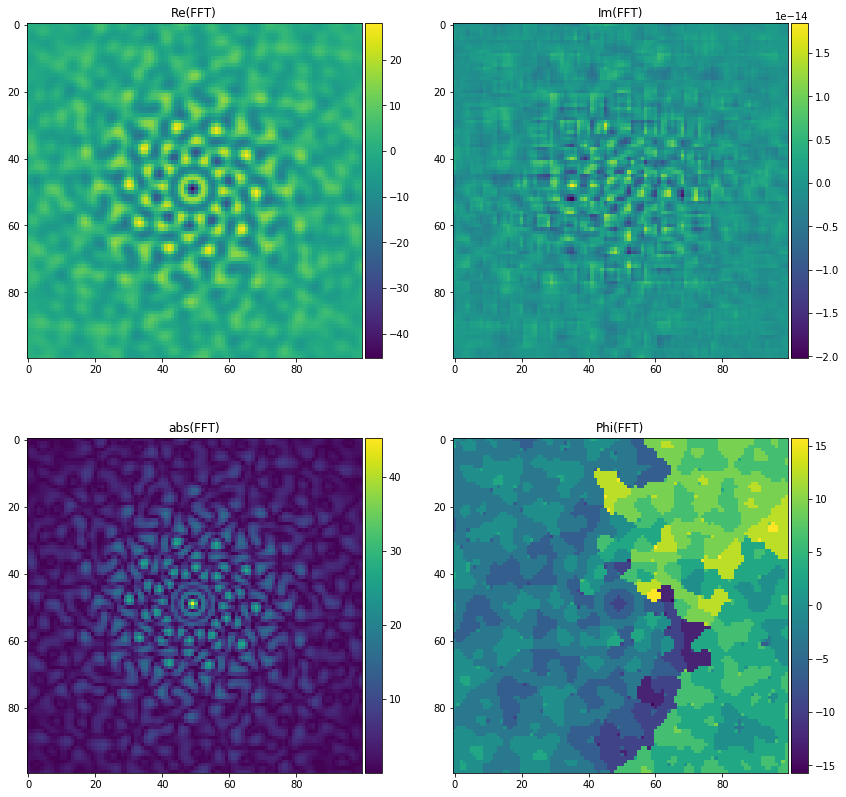

In [21]:
import matplotlib.pyplot as plt
from skimage.restoration import unwrap_phase

fig, axes = plt.subplots(2, 2, figsize=(14,14))
plt.axes(axes[0][0])
plt.title('Re(FFT)')
wrapcb(plt.imshow(ideal_fft[0][975:1075,975:1075],cmap='viridis'))
plt.axes(axes[0][1])
plt.title('Im(FFT)')
wrapcb(plt.imshow(ideal_fft[1][975:1075,975:1075],cmap='viridis'))
plt.axes(axes[1][0])
plt.title('abs(FFT)')
wrapcb(plt.imshow(np.abs(ideal_fft_complex)[975:1075,975:1075],cmap='viridis'))
plt.axes(axes[1][1])
plt.title('Phi(FFT)')
wrapcb(plt.imshow(unwrap_phase(np.angle(ideal_fft_complex))[975:1075,975:1075],cmap='viridis'))
plt.show()

In [22]:
ideal_ift = np.fft.fftshift(np.fft.ifft2(np.fft.fftshift(ideal_fft_complex)))

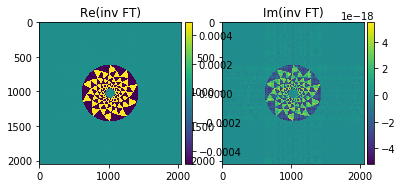

In [23]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 2, figsize=(6,14))
plt.axes(axes[0])
plt.title('Re(inv FT)')
wrapcb(plt.imshow(np.real(ideal_ift),cmap='viridis'))
plt.axes(axes[1])
plt.title('Im(inv FT)')
wrapcb(plt.imshow(np.imag(ideal_ift),cmap='viridis'))
plt.show()

In [24]:
# Normalise
ideal_scaled = np.real(ideal_ift) / np.max(np.real(ideal_ift).flatten())
ideal_scaled_complex = ideal_ift / np.max(np.real(ideal_ift).flatten())

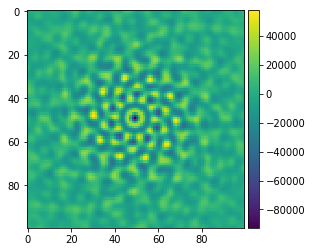

In [25]:
# Check we can reconstruct the desired PSF
fig=plt.figure()
wrapcb(plt.imshow(np.real(np.fft.fftshift(np.fft.fft2(np.fft.fftshift(ideal_scaled_complex)))[975:1075,975:1075]),cmap='viridis'))
plt.show()

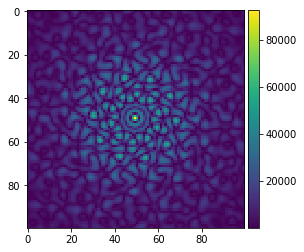

In [26]:
# Check we can reconstruct the desired PSF
fig=plt.figure()
wrapcb(plt.imshow(np.abs(np.fft.fftshift(np.fft.fft2(np.fft.fftshift(ideal_scaled_complex)))[975:1075,975:1075]),cmap='viridis'))
plt.show()

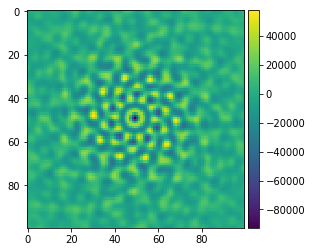

In [27]:
# Check it's just the real component
fig=plt.figure()
wrapcb(plt.imshow(np.real(np.fft.fftshift(np.fft.fft2(np.fft.fftshift(ideal_scaled + 0j)))[975:1075,975:1075]),cmap='viridis'))
plt.show()

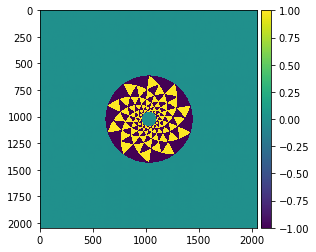

In [28]:
# Visualise inverted FT
fig=plt.figure()
wrapcb(plt.imshow(ideal_scaled,cmap='viridis'))
plt.show()

In [29]:
# Looks very similar to what we've got, except for a uniform phase shift
wf = np.multiply(np.exp((2*np.pi*complex(0., 1.)/(wl*1e-9))*(opdmap+650.*1e-9*0.5)), aperture)

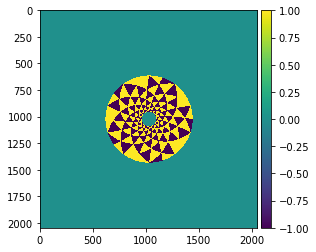

In [30]:
fig=plt.figure()
wrapcb(plt.imshow(np.real(wf),cmap='viridis'))
plt.show()

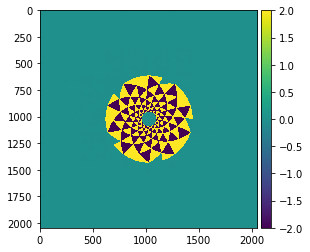

In [31]:
# So what's the difference?
pupil_residual = np.real(wf) - ideal_scaled
fig=plt.figure()
wrapcb(plt.imshow(pupil_residual,cmap='viridis'))
plt.show()

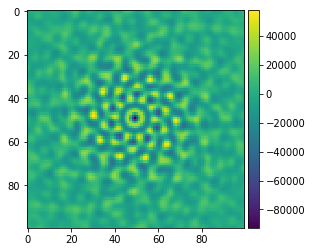

In [32]:
# Looks like a tiny residual. Can this really be the source of the problem?
pupil_residual
fig=plt.figure()
wrapcb(plt.imshow(np.real(np.fft.fftshift(np.fft.fft2(np.fft.fftshift(ideal_scaled + 0j)))[975:1075,975:1075]),cmap='viridis'))
plt.show()

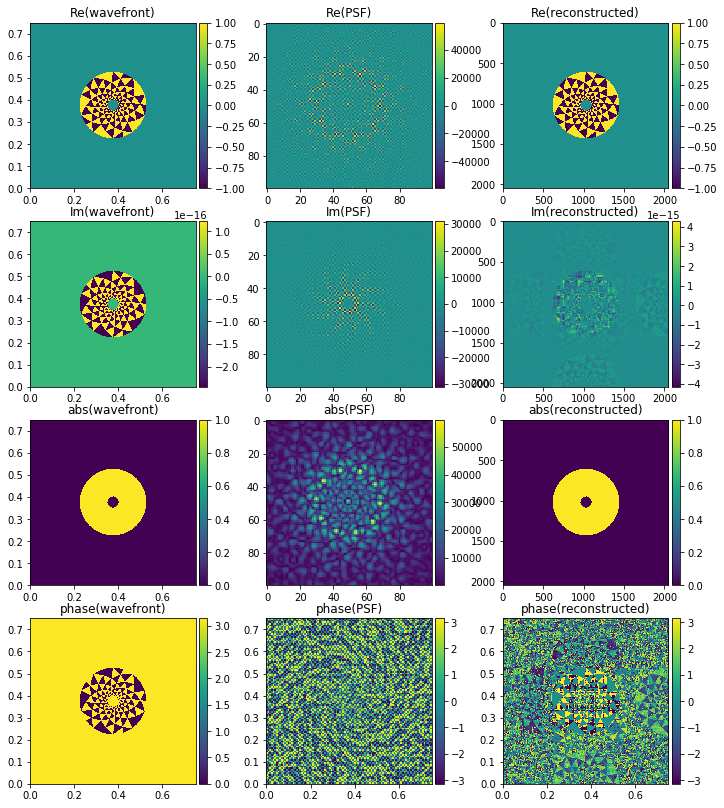

In [33]:
wl = 650.

fig, axes = plt.subplots(4, 3, figsize=(12,14))

#wf = np.multiply(np.exp((2*np.pi*complex(0., 1.)/(wl*1e-9))*opdmap*-1.), aperture)
plt.axes(axes[0][0])
plt.title('Re(wavefront)')
wrapcb(plt.imshow(np.real(wf),cmap='viridis',extent=[x*sampling for x in [0,gridsize,0,gridsize]]))
plt.axes(axes[1][0])
plt.title('Im(wavefront)')
wrapcb(plt.imshow(np.imag(wf),cmap='viridis',extent=[x*sampling for x in [0,gridsize,0,gridsize]]))
plt.axes(axes[2][0])
plt.title('abs(wavefront)')
wrapcb(plt.imshow(np.abs(wf),cmap='viridis',extent=[x*sampling for x in [0,gridsize,0,gridsize]]))
plt.axes(axes[3][0])
plt.title('phase(wavefront)')
wrapcb(plt.imshow(np.angle(wf),cmap='viridis',extent=[x*sampling for x in [0,gridsize,0,gridsize]]))

ft = np.fft.fft2(wf)
ft_shifted = np.fft.fftshift(ft)
plt.axes(axes[0][1])
plt.title('Re(PSF)')
wrapcb(plt.imshow(np.real(ft_shifted[975:1075,975:1075]),cmap='viridis'))
plt.axes(axes[1][1])
plt.title('Im(PSF)')
wrapcb(plt.imshow(np.imag(ft_shifted[975:1075,975:1075]),cmap='viridis'))
plt.axes(axes[2][1])
plt.title('abs(PSF)')
wrapcb(plt.imshow(np.abs(ft_shifted[975:1075,975:1075]),cmap='viridis'))
plt.axes(axes[3][1])
plt.title('phase(PSF)')
wrapcb(plt.imshow(np.angle(ft_shifted[975:1075,975:1075]),cmap='viridis',extent=[x*sampling for x in [0,gridsize,0,gridsize]]))

ift = np.fft.ifft2(ft)
plt.axes(axes[0][2])
plt.title('Re(reconstructed)')
wrapcb(plt.imshow(np.real(ift),cmap='viridis'))
plt.axes(axes[1][2])
plt.title('Im(reconstructed)')
wrapcb(plt.imshow(np.imag(ift),cmap='viridis'))
plt.axes(axes[2][2])
plt.title('abs(reconstructed)')
wrapcb(plt.imshow(np.abs(ift),cmap='viridis'))
plt.axes(axes[3][2])
plt.title('phase(reconstructed)')
wrapcb(plt.imshow(np.angle(ift),cmap='viridis',extent=[x*sampling for x in [0,gridsize,0,gridsize]]))

plt.show()